# Reactor Kinetics Example 

Jialu Wang (jwang44@nd.edu) and Alex Dowling (adowling@nd.edu)

University of Notre Dame

This notebook conducts design of experiments for a reactor kinetics experiment with the Pyomo.DOE.
    

In [1]:
import matplotlib.pyplot as plt
from pyomo.environ import *
from pyomo.dae import *

import numpy as np
from scipy.interpolate import interp2d
import pandas as pd 
from itertools import permutations, product, combinations
import idaes

from fim_doe import *
#from pyomo.contrib.sensitivity_toolbox.sens import sipopt
#from idaes.apps.uncertainty_propagation.sens import get_dsdp
#from pyomo.contrib.sensitivity_toolbox.sens import get_dsdp

## Define Reaction Example Mathematical Model

Consider two chemical reactions that converts molecule $A$ to desired product $B$ and a less valuable side-product $C$.

$A \overset{k_1}{\rightarrow} B \overset{k_2}{\rightarrow} C$

Our ultimate goals is to design a large-scale continous reactor that maximizes the production of $B$. This general sequential reactions problem is widely applicable to CO$_2$ capture and industry more broadly (petrochemicals, pharmasuticals, etc.).

The rate laws for these two chemical reactions are:

$r_A = -k_1 C_A$

$r_B = k_1 C_A - k_2 C_B$

$r_C = k_2 C_B$

Here, $C_A$, $C_B$, and $C_C$ are the concentrations of each species. The rate constants $k_1$ and $k_2$ depend on temperature as follows:

$k_1 = A_1 \exp{\frac{-E_1}{R T}}$

$k_2 = A_2 \exp{\frac{-E_2}{R T}}$

$A_1, A_2, E_1$, and $E_2$ are fitted model parameters. $R$ is the ideal-gas constant and $T$ is absolute temperature.

Using the **CCSI$^2$ toolset**, we would like do the following perform:

Perform **uncertainty quantification** and **design of experiments** on a small-scale **batch reactor** to infer parameters $A_1$, $A_2$, $E_1$, and $E_2$.

### Batch reactor

The concenrations in a batch reactor evolve with time per the following differential equations:

$$ \frac{d C_A}{dt} = r_A = -k_1 C_A $$

$$ \frac{d C_B}{dt} = r_B = k_1 C_A - k_2 C_B $$

$$ \frac{d C_C}{dt} = r_C = k_2 C_B $$

This is a linear system of differential equations. Assuming the feed is only species $A$, i.e., 

$$C_A(t=0) = C_{A0} \quad C_B(t=0) = 0 \quad C_C(t=0) = 0$$

When the temperature is constant, it leads to the following analytic solution:

$$C_A(t) = C_{A,0} \exp(-k_1 t)$$

$$C_B(t) = \frac{k_1}{k_2 - k_1} C_{A,0} \left[\exp(-k_1 t) - \exp(-k_2 t) \right]$$

$$C_C(t) = C_{A,0} - \frac{k_2}{k_2 - k_1} C_{A,0} \exp(-k_1 t) + \frac{k_1}{k_2 - k_1} \exp(-k_2 t) C_{A,0} = C_{A,0} - C_{A}(t) - C_{B}(t)$$

In [2]:
from reactor_kinetics import *

Three versions of this model is accomplished: 

Dynamic-DAE model: Temperature varying model discretized and integrated by Pyomo.DAE

Constant-DAE model: Temperature constant model discretized and integrated by Pyomo.DAE

Constant-analytical model: Temperature constant model discretized manually and using the analytical expressions for state variables.

In [3]:

createmod = create_model
#args_ = [True, False, False]
disc = disc_for_measure
t_control = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]
    
# design variable and its control time set
dv_pass = {'CA0': [0],'T': t_control}
    

# Define measurement time points
t_measure = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]
#t_measure_ca = [0, 0.25, 0.5, 0.75, 1]
#t_measure_cb = [0, 0.125, 0.375, 0.625, 0.875, 1]
#measure_pass = {'CA': t_measure, 'CB': t_measure, 'CC': t_measure}
#measure_pass = {'C':{"'CA'": t_measure, "'CB'": t_measure, "'CC'": t_measure}}
measure_pass = {'C':{'CA': t_measure, 'CB': t_measure, 'CC': t_measure}}
#measure_pass = {'C':{'CA': t_measure_ca, 'CB': t_measure_cb, 'CC': t_measure}}
measure_class =  Measurements(measure_pass)
'''
comb = [t_measure, t_measure_ca, t_measure_cb]
#unique = list(set(t_measure_ca+t_measure_cb))
d = []
for i in comb:
    d += i
    unique = list(set((d)))

print(unique)
'''

All measurements are flattened.
Flatten measurement name: ['C_index_CA', 'C_index_CB', 'C_index_CC']
Flatten measurement variance: {'C_index_CA': 1, 'C_index_CB': 1, 'C_index_CC': 1}


'\ncomb = [t_measure, t_measure_ca, t_measure_cb]\n#unique = list(set(t_measure_ca+t_measure_cb))\nd = []\nfor i in comb:\n    d += i\n    unique = list(set((d)))\n\nprint(unique)\n'

In [4]:
# Define parameter nominal value 
parameter_dict = {'A1': 84.79085853498033, 'A2': 371.71773413976416, 'E1': 7.777032028026428, 'E2': 15.047135137500822}

def generate_exp(t_set, CA0, T):  
    '''Generate experiments. 
    t_set: time control set for T.
    CA0: CA0 value
    T: A list of T 
    '''
    assert(len(t_set)==len(T)), 'T should have the same length as t_set'
    
    T_con_initial = {}
    for t, tim in enumerate(t_set):
        T_con_initial[tim] = T[t]
        
    dv_dict_overall = {'CA0': {0: CA0},'T': T_con_initial}
    return dv_dict_overall

In [5]:
# empty prior
prior_all = np.zeros((4,4))


# add prior information
#prior_5_300 = pd.read_csv('fim_5_300_scale.csv')
#prior_5_300_500 = pd.read_csv('fim_5_300_500_scale.csv')

#prior_all = prior_5_300


prior_pass=np.asarray(prior_all)

#L_initials = np.linalg.cholesky(prior_pass)
#print(L_initials)

print('The prior information FIM:', prior_pass)
print('Prior Det:', np.linalg.det(prior_pass))
print('Eigenvalue of the prior experiments FIM:', np.linalg.eigvals(prior_pass))
print('Eigenvalue of the prior experiments FIM:', np.linalg.eigh(prior_pass)[1])

The prior information FIM: [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Prior Det: 0.0
Eigenvalue of the prior experiments FIM: [0. 0. 0. 0.]
Eigenvalue of the prior experiments FIM: [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


## Compute FIM 

This method computes an MBDoE optimization problem with no Degree of Freedom.

In [15]:
# choose from 'simultaneous', 'sequential', 'sipopt'
#sensi_opt = 'sequential_finite'
#sensi_opt = 'sequential_sipopt'
#sensi_opt = 'sequential_kaug'
sensi_opt = 'direct_kaug'


if sensi_opt == 'direct_kaug':
    args_ = [False]
else:
    args_ = [True]
    

# Define experiments
#if (model_opt=='dynamic-DAE') or (model_opt=='dynamic-DAE-measure'):
exp1 = generate_exp(t_control, 5, [570, 300, 300, 300, 300, 300, 300, 300, 300])
#exp1 = generate_exp(t_control, 5, [300, 300, 300, 300, 300, 300, 300, 300, 300])
#else: 
#    exp1 = generate_exp(t_control, 5, [300])

print('Design variable:', exp1)

Design variable: {'CA0': {0: 5}, 'T': {0: 570, 0.125: 300, 0.25: 300, 0.375: 300, 0.5: 300, 0.625: 300, 0.75: 300, 0.875: 300, 1: 300}}


In [16]:
doe_object = DesignOfExperiments(parameter_dict, dv_pass,
                                 measure_class, createmod,
                                prior_FIM=prior_pass, discretize_model=disc, args=args_)

if_s = True

result = doe_object.compute_FIM(exp1,mode=sensi_opt, FIM_store_name = 'dynamic.csv', 
                                store_output = 'store_output', read_output=None,
                                scale_nominal_param_value=if_s, formula='central')


result.calculate_FIM(doe_object.design_values)


Sensitivity information is scaled by its corresponding parameter nominal value.
After practice: {'C_index_CA': [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1], 'C_index_CB': [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1], 'C_index_CC': [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]}
Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt

In [17]:
print('======Result summary======')
print('Four design criteria log10() value:')
print('A-optimality:', np.log10(result.trace))
print('D-optimality:', np.log10(result.det))
print('E-optimality:', np.log10(result.min_eig))
print('Modified E-optimality:', np.log10(result.cond))

======Result summary======
Four design criteria log10() value:
A-optimality: 2.7885870986635575
D-optimality: 2.8218409166133323
E-optimality: -1.0123469424440517
Modified E-optimality: 3.7814034299088752


In [14]:
result.FIM[0][2]

-70.238194792475

## Optimization

In [18]:
exp1 = generate_exp(t_control, 5, [300, 300, 300, 300, 300, 300, 300, 300, 300])

In [19]:
doe_object = DesignOfExperiments(parameter_dict, dv_pass,
                                 measure_class, createmod,
                                prior_FIM=prior_pass, discretize_model=disc, args=[True])

square_result, optimize_result= doe_object.optimize_doe(exp1, if_optimize=True, if_Cholesky=True, 
                                                         scale_nominal_param_value=True, objective_option='det', 
                                                         L_initial=None)


Sensitivity information is scaled by its corresponding parameter nominal value.
    'pyomo.core.base.set.OrderedScalarSet'>) on block unknown with a new
    Component (type=<class 'pyomo.core.base.set.AbstractOrderedScalarSet'>).
    This is usually indicative of a modelling error. To avoid this warning,
    use block.del_component() and block.add_component().
    'pyomo.core.base.objective.ScalarObjective'>) on block unknown with a new
    Component (type=<class 'pyomo.core.base.objective.ScalarObjective'>). This
    is usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://

  73r-1.4681247e+01 2.23e+00 1.52e+03  -4.0 3.12e+02    -  8.75e-01 1.00e-01f  1
  74r-1.4909251e+01 2.67e+00 9.10e+02  -4.0 3.41e+02    -  4.48e-01 6.60e-02f  1
  75r-1.5013461e+01 2.70e+00 1.45e+03  -4.0 3.53e+02    -  5.42e-01 3.19e-02f  1
  76r-1.5134417e+01 2.87e+00 1.39e+03  -4.0 3.10e+02    -  6.56e-02 4.20e-02f  1
  77r-1.5558296e+01 6.46e+00 1.17e+03  -4.0 3.21e+02    -  5.77e-02 1.56e-01f  1
  78r-1.5998003e+01 9.32e+00 9.57e+02  -4.0 3.50e+02    -  3.06e-01 1.84e-01f  1
  79r-1.6062384e+01 9.10e+00 9.27e+02  -4.0 3.65e+02    -  2.66e-01 3.09e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80r-1.6187119e+01 8.79e+00 8.67e+02  -4.0 3.64e+02    -  1.00e+00 6.17e-02f  1
  81r-1.6302074e+01 8.54e+00 8.50e+02  -4.0 3.36e+02    -  5.14e-01 6.26e-02f  1
  82r-1.6318847e+01 8.47e+00 8.77e+02  -4.0 3.34e+02    -  3.35e-01 9.61e-03f  1
  83r-1.6320517e+01 8.46e+00 9.09e+02  -4.0 3.33e+02    -  4.41e-01 9.68e-04h  1
  84r-1.6321820e+01 8.45e+00

 211r-3.2167548e+01 2.77e+01 2.46e+02  -9.0 1.26e+03    -  1.00e+00 1.50e-03h  1
 212r-3.2178886e+01 2.66e+01 2.36e+02  -9.0 1.26e+03    -  1.00e+00 4.32e-02h  1
 213r-3.2216198e+01 2.40e+01 2.00e+02  -9.0 1.20e+03    -  1.00e+00 1.54e-01h  1
 214r-3.2232831e+01 2.24e+01 1.83e+02  -9.0 1.04e+03    -  1.00e+00 8.06e-02h  1
 215r-3.2233397e+01 2.23e+01 1.80e+02  -9.0 9.50e+02    -  1.00e+00 3.08e-03h  1
 216r-3.2387415e+01 2.92e+01 2.62e+01  -9.0 9.47e+02    -  1.00e+00 8.54e-01h  1
 217r-3.2398810e+01 1.76e+01 2.50e+01  -9.0 1.80e+02    -  1.00e+00 4.04e-01h  1
 218r-3.2415874e+01 3.48e-01 4.78e-04  -9.0 1.08e+02    -  1.00e+00 1.00e+00h  1
 219r-3.2415930e+01 7.95e-02 4.89e-07  -9.0 3.03e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220r-3.2415931e+01 7.95e-02 2.75e-10  -9.0 4.91e-03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 220

                                   (scaled)                 (unscaled)
Object

   4 -3.2558526e+01 2.08e+05 5.11e+02  -1.0 3.01e+04    -  8.06e-01 9.41e-05h 10
   5 -3.2558668e+01 2.08e+05 5.11e+02  -1.0 2.49e+04    -  1.04e-03 4.42e-05h 11
   6 -3.2558376e+01 2.08e+05 5.11e+02  -1.0 1.21e+05    -  3.09e-04 1.55e-05h 13
   7 -3.2469523e+01 2.07e+05 5.46e+02  -1.0 1.24e+05    -  4.40e-02 3.90e-03h  5
   8 -3.2506320e+01 2.07e+05 1.19e+03  -1.0 1.11e+05    -  4.56e-03 3.52e-03h  5
   9 -3.2648666e+01 2.07e+05 1.81e+03  -1.0 1.01e+05    -  2.33e-02 3.31e-03h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -3.2852711e+01 2.07e+05 2.00e+03  -1.0 9.37e+04    -  7.67e-02 1.65e-03h  6
  11 -3.3014828e+01 2.07e+05 2.02e+03  -1.0 9.93e+04    -  5.52e-03 5.01e-04h  8
  12 -2.8845486e+01 3.61e+06 6.19e+05  -1.0 1.06e+05    -  4.63e-01 7.19e-02w  1
Reallocating memory for MA57: lfact (357632)
  13 -2.9906330e+01 3.61e+06 6.25e+05  -1.0 2.14e+04  -2.0 1.31e-02 9.18e-03w  1
  14 -3.1644603e+01 3.59e+06 7.01e+05  -1.0 1.52e+04  -1.6 5.21e

Scaling factors are invalid - setting them all to 1.
  95 -2.5007723e+01 9.28e+02 4.45e+02  -1.0 1.37e+04    -  8.93e-01 2.18e-02h  1
  96 -2.5057374e+01 9.28e+02 1.02e+03  -1.0 5.87e+04    -  1.27e-02 5.95e-04h  5
  97 -2.5154263e+01 9.28e+02 2.52e+03  -1.0 6.46e+04    -  1.20e-02 5.04e-04h  5
  98 -2.5962083e+01 9.26e+02 6.73e+03  -1.0 1.64e+04    -  1.68e-02 2.23e-03h  3
  99 -1.6756898e+01 9.21e+02 8.61e+03  -1.0 2.25e+04    -  1.19e-02 5.59e-04H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 -1.6759923e+01 9.20e+02 7.57e+03  -1.0 2.14e+04    -  7.18e-05 6.18e-04h  4
 101 -1.6761404e+01 9.20e+02 3.37e+05  -1.0 2.72e+04    -  1.62e-01 2.91e-04h  5
 102 -1.6763699e+01 9.20e+02 3.54e+05  -1.0 4.28e+04    -  5.22e-04 1.20e-04h  7
 103 -1.6766518e+01 9.20e+02 3.91e+05  -1.0 3.03e+04    -  1.39e-03 1.72e-04h  7
 104 -1.6773497e+01 9.19e+02 8.48e+06  -1.0 2.63e+04    -  2.69e-01 3.97e-04h  6
 105 -1.7471975e+01 4.88e+02 3.38e+05  -1.0 3.84e+01   1

 185 -3.3303671e+01 2.66e+04 1.81e+06  -1.0 3.43e+03  -1.0 2.29e-03 2.94e-03h  1
 186 -3.3275270e+01 2.65e+04 1.72e+06  -1.0 1.17e+05    -  2.75e-02 3.91e-03h  1
 187 -3.3217089e+01 2.63e+04 1.74e+06  -1.0 1.52e+05    -  5.11e-04 8.29e-03f  1
 188 -3.3217067e+01 2.63e+04 1.31e+06  -1.0 1.03e+04  -1.5 8.39e-03 1.13e-04h  1
 189 -3.3215303e+01 2.60e+04 1.29e+06  -1.0 1.07e+04  -2.0 2.52e-03 1.07e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190 -3.3212168e+01 2.60e+04 1.29e+06  -1.0 2.57e+04  -2.4 1.44e-03 4.93e-04h  1
 191 -3.3211307e+01 2.60e+04 1.29e+06  -1.0 1.02e+04  -2.0 7.65e-03 1.55e-03h  1
 192 -3.3211321e+01 2.60e+04 1.29e+06  -1.0 1.10e+04  -1.6 9.61e-03 1.95e-04h  1
 193 -3.3212207e+01 2.59e+04 1.29e+06  -1.0 1.10e+04  -2.1 3.20e-03 2.42e-03h  1
 194 -3.3164093e+01 2.58e+04 1.28e+06  -1.0 4.27e+05    -  3.88e-04 3.09e-03h  1
 195 -3.3164321e+01 2.58e+04 1.28e+06  -1.0 1.13e+04  -1.6 2.82e-04 5.46e-04h  1
 196 -3.3163084e+01 2.58e+04

 277 -5.1849266e+00 4.87e+04 2.58e+10  -1.0 9.88e+02   0.9 3.22e-01 4.87e-02h  1
 278 -5.1852839e+00 4.87e+04 2.58e+10  -1.0 2.67e+03   0.4 7.57e-02 5.53e-04h  1
Reallocating memory for MA57: lfact (980899)
 279 -5.3214263e+00 4.48e+04 2.40e+10  -1.0 1.42e+04  -0.0 5.04e-02 8.68e-02h  1
Reallocating memory for MA57: lfact (1724223)
Reallocating memory for MA57: lfact (1997043)
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280 -5.3226344e+00 4.47e+04 2.40e+10  -1.0 1.16e+03  -0.5 5.46e-01 1.55e-03h  1
 281 -5.4530908e+00 4.57e+04 2.39e+10  -1.0 3.06e+07    -  1.24e-06 1.01e-03f  3
Reallocating memory for MA57: lfact (2762504)
 282 -5.5044169e+00 4.49e+04 2.35e+10  -1.0 4.37e+02   1.7 5.48e-01 1.69e-02h  1
 283 -5.5266158e+00 4.45e+04 2.33e+10  -1.0 4.88e+02   1.2 9.49e-01 9.37e-03h  1
 284 -5.9162964e+00 4.35e+04 2.28e+10  -1.0 4.08e+05    -  1.66e-01 2.40e-02h  2
 285 -5.9236102e+00 4.33e+04 2.27e+10  -1.0 1.19e+03   0.8 6.08e-01 4.00e-03h  2
 286 -6

 365 -3.5344859e+01 1.30e+03 8.99e+14  -1.0 3.16e+00  14.5 1.00e+00 1.00e+00h  1
 366r-3.5344859e+01 1.30e+03 1.00e+03   3.1 0.00e+00    -  0.00e+00 8.52e-08R  2
 367r-3.5354882e+01 9.79e+02 1.21e+05   3.1 1.30e+06    -  1.44e-01 9.91e-04f  1
 368 -3.6968975e+01 6.85e+04 9.04e+00  -1.0 9.29e+04    -  1.00e+00 1.00e+00h  1
 369 -3.6481567e+01 4.06e+04 1.11e+01  -1.0 8.78e+04    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 370 -3.6103031e+01 7.31e+03 1.04e+01  -1.0 9.03e+04    -  1.00e+00 1.00e+00h  1
 371 -3.6244033e+01 4.00e+00 8.15e-02  -1.0 1.52e+03    -  1.00e+00 1.00e+00h  1
 372 -3.6237597e+01 3.39e-02 1.02e-03  -1.0 2.99e+02    -  1.00e+00 1.00e+00h  1
 373 -3.6585976e+01 3.55e+03 9.17e+00  -2.5 1.02e+05    -  8.90e-01 1.00e+00f  1
 374 -3.7308182e+01 2.78e+04 3.74e+01  -2.5 2.61e+05    -  1.00e+00 1.00e+00h  1
 375 -3.7775305e+01 6.30e+04 2.23e+01  -2.5 3.20e+05    -  1.00e+00 1.00e+00h  1
 376 -3.7686978e+01 1.17e+03

======Result summary======
This optimization is solved with status: converged
The result FIM is: [[  17.22555255   14.38327112  -36.46377844  -71.12350272]
 [  14.38327112   34.96951087  -27.34621792 -169.6020682 ]
 [ -36.46377844  -27.34621792   78.37663227  136.01315753]
 [ -71.12350272 -169.6020682   136.01315753  829.48817501]]
Four design criteria log10() value:
A-optimality: 2.9822983171039357
D-optimality: 3.303190545570546
E-optimality: -0.9184300249628171
Modified E-optimality: 3.870172018135002
477.1345046398719
300.0002076371097



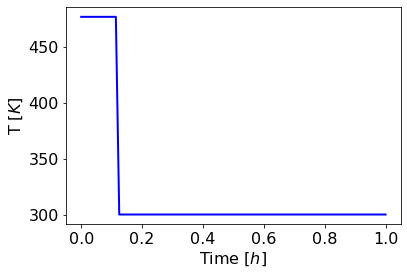

In [24]:
print('======Result summary======')
print('This optimization is solved with status:', optimize_result.status)
#print('It gives solution:', optimize_result.solution)
#print('The log10(OF) optimized is:', optimize_result.obj_value)
print('The result FIM is:', optimize_result.FIM)
print('Four design criteria log10() value:')
print('A-optimality:', np.log10(optimize_result.trace))
print('D-optimality:', np.log10(optimize_result.det))
print('E-optimality:', np.log10(optimize_result.min_eig))
print('Modified E-optimality:', np.log10(optimize_result.cond))

t_list = []
for t in optimize_result.model.t:
    t_list.append(t)

T_list = []
for i in t_list:
    T_list.append(value(optimize_result.model.T[i]))

print(value(optimize_result.model.T[0]))
print(value(optimize_result.model.T[1]))
print()
    
si=16
plt.rc('axes', titlesize=si)
plt.rc('axes', labelsize=si)
plt.rc('xtick', labelsize=si)
plt.rc('ytick', labelsize=si)
plt.rc('legend', fontsize=12)
    
plt.plot(t_list, T_list, 'b', linewidth=2)
#plt.scatter(t_list, T_list, 'b')
plt.ylabel('T [$K$]')
plt.xlabel('Time [$h$]')
plt.show()

## Grid search for 2 design variables

In [ ]:
design_ranges = [list(np.linspace(1,5,9)), list(np.linspace(300,700,9))]

dv_apply_name = ['CA0','T']

dv_apply_time = [[0],t_control]

# Define experiments
if (model_opt=='dynamic-DAE'):
    exp1 = generate_exp(t_control, 5, [570.21, 300, 300, 300, 300, 300, 300, 300, 300])
else: 
    exp1 = generate_exp(t_control, 5, [500])
    
# choose from 'simultaneous', 'sequential', 'sipopt'
#sensi_opt = 'simultaneous_finite'

sensi_opt = 'sequential_finite'
#sensi_opt = 'sequential_sipopt'
#sensi_opt = 'sequential_kaug'
#sensi_opt = 'direct_kaug'

#if sensi_opt == 'direct_kaug':
#    args_[2] = True

In [ ]:
doe_object = DesignOfExperiments(parameter_dict, dv_pass, 
                                 ['CA','CB','CC'], t_measure, createmod,
                                 prior_FIM=prior_pass, discretize_model=disc, args=None)

all_fim = doe_object.run_grid_search(exp1, design_ranges,dv_apply_name, dv_apply_time, 
                                     mode=sensi_opt, 
                                    scale_nominal_param_value=True
                                    )

### 1D sensitivity curve

In [ ]:
test = all_fim.extract_criteria()

## draw 1D sensitivity curve 

fixed = {"'CA0'": 5.0}

all_fim.figure_drawing(fixed, ['T'], 'Reactor case','T [K]','$C_{A0}$ [M]' )



## Heatmap

In [ ]:
fixed = {}
all_fim.figure_drawing(fixed, ['CA0','T'], 'Reactor case','$C_{A0}$ [M]', 'T [K]' )

## Grid search for 3 design variables

In [ ]:

#design_ranges = [list(np.linspace(1,5,2)),  list(np.linspace(300,700,2)), [300,500]]
design_ranges = [list(np.linspace(1,5,2)),  list(np.linspace(300,700,2)), [300,500]]

dv_apply_name = ['CA0', 'T', 'T']
dv_apply_time = [[0], [0], [0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875,1]]

# Define experiments
if (model_opt=='dynamic-DAE'):
    exp1 = generate_exp(t_control, 5, [570.21, 300, 300, 300, 300, 300, 300, 300, 300])
else: 
    exp1 = generate_exp(t_control, 5, [500])

In [ ]:
doe_object = DesignOfExperiments(parameter_dict, dv_pass, 
                                 ['CA','CB','CC'], t_measure, createmod,
                                 prior_FIM=prior_pass, discretize_model=disc)

all_fim = doe_object.run_grid_search(exp1, design_ranges,dv_apply_name, dv_apply_time, 
                                     mode='sequential_finite', 
                                    scale_nominal_param_value=True
                                    )

### Draw 1D sensitivity curve

In [ ]:
test = all_fim.extract_criteria()

In [ ]:
## draw 1D sensitivity curve 

fixed = {"'CA0'": 1.0, "'T2'": 300}

all_fim.figure_drawing(fixed, ['T'], 'Reactor case','T [K]','$C_{A0}$ [M]' )

### Draw 2D sensitivity curve

In [ ]:
fixed = {"'T2'": 300}

all_fim.figure_drawing(fixed, ['CA0','T'], 'Reactor case','$C_{A0}$ [M]', 'T [K]' )